<a href="https://colab.research.google.com/github/tanoojoy/Appcues-Arcadier/blob/main/Copy_of_deep_learning_Added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
himeshghoora_iet_codefest_2025_path = kagglehub.dataset_download('himeshghoora/iet-codefest-2025')

print('Data source import complete.')


100%|██████████| 5.55G/5.55G [01:01<00:00, 96.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
import os
print(os.listdir(himeshghoora_iet_codefest_2025_path))

['the_dataset']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


🌲 Random Forest
✅ Accuracy: 83.12 %
✅ Weighted F1 Score: 83.32 %
✅ Weighted Precision: 84.64 %


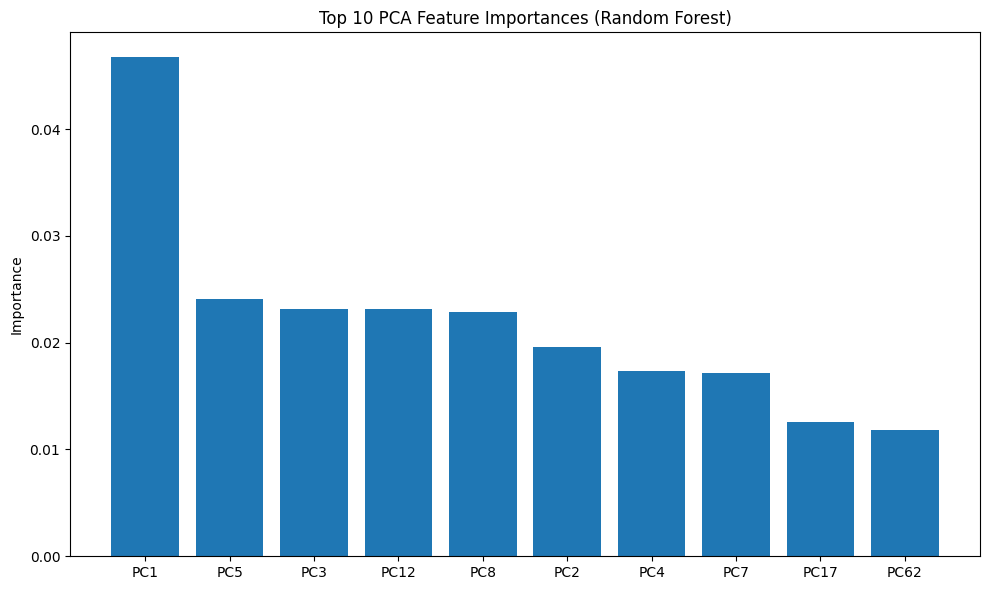


🧠 ANN
✅ Accuracy: 74.03 %
✅ Weighted F1 Score: 74.01 %
✅ Weighted Precision: 74.93 %

📋 Classification Report (ANN):
                   precision    recall  f1-score   support

           No_DR       0.94      0.98      0.96        46
            Mild       0.76      0.61      0.67        46
        Moderate       0.66      0.72      0.69        46
          Severe       0.79      0.66      0.72        47
Proliferative_DR       0.60      0.74      0.66        46

        accuracy                           0.74       231
       macro avg       0.75      0.74      0.74       231
    weighted avg       0.75      0.74      0.74       231



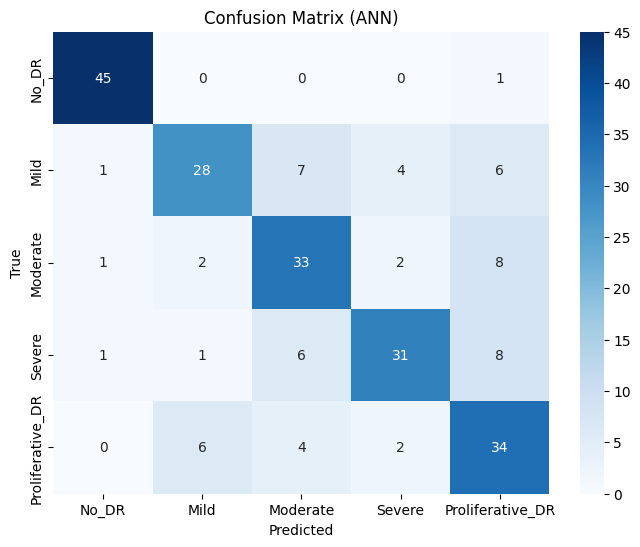

In [ ]:
# 📦 Imports
import os, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # ✅ Fix for corrupted images

import matplotlib.pyplot as plt, seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# 🧠 Label setup
label_map = {'No_DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferative_DR': 4}
df = pd.read_csv(os.path.join(himeshghoora_iet_codefest_2025_path, 'the_dataset', 'labels.csv'))
df['encoded_label'] = df['label'].map(label_map)

# 🔧 Normalize image paths
df['image_path'] = df['image_path'].str.replace(r'\\', '/', regex=True)
# Correct the image path joining
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(himeshghoora_iet_codefest_2025_path, x))

# ⚖️ Balance dataset safely
dfs = []
max_size = df['encoded_label'].value_counts().max()
for label in df['encoded_label'].unique():
    subset = df[df['encoded_label'] == label]
    if len(subset) == 0:
        continue
    subset = resample(subset, replace=True, n_samples=max_size, random_state=42)
    dfs.append(subset)
df_balanced = pd.concat(dfs).reset_index(drop=True)

# 🔀 Split dataset
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['encoded_label'], random_state=42)

# 🖼️ Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# 🧠 Feature extractor using pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet.eval()

def extract_features(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)
        with torch.no_grad():
            features = resnet(image).squeeze().numpy()
        return features
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# 🧪 Extract features
def build_feature_matrix(df):
    X, y = [], []
    for _, row in df.iterrows():
        features = extract_features(row['image_path'])
        if features is not None:
            X.append(features)
            y.append(row['encoded_label'])
    return np.array(X), np.array(y)

X_train_raw, y_train = build_feature_matrix(train_df)
X_val_raw, y_val = build_feature_matrix(val_df)

# 🔻 Dimensionality reduction
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train_raw)
X_val = pca.transform(X_val_raw)

# 💾 Save PCA
joblib.dump(pca, 'pca.pkl')

# 🌲 Random Forest
rf_model = RandomForestClassifier(n_estimators=300, max_depth=25, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'model.pkl')

# 📊 RF Evaluation
rf_preds = rf_model.predict(X_val)
print("🌲 Random Forest")
print("✅ Accuracy:", round(accuracy_score(y_val, rf_preds) * 100, 2), "%")
print("✅ Weighted F1 Score:", round(f1_score(y_val, rf_preds, average='weighted') * 100, 2), "%")
print("✅ Weighted Precision:", round(precision_score(y_val, rf_preds, average='weighted') * 100, 2), "%")

# 📈 RF Feature importance
importances = rf_model.feature_importances_
top_indices = np.argsort(importances)[-10:][::-1]
plt.figure(figsize=(10,6))
plt.bar(range(10), importances[top_indices], tick_label=[f'PC{i+1}' for i in top_indices])
plt.title('Top 10 PCA Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 🧱 PyTorch Dataset for ANN
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = FeatureDataset(X_train, y_train)
val_dataset = FeatureDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 🧠 Simple ANN
class SimpleANN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann_model = SimpleANN(input_dim=100, num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.001)

# 🔁 Train ANN
ann_model.train()
for epoch in range(10):
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = ann_model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 💾 Save ANN
torch.save(ann_model.state_dict(), 'ann_model.pt')

# 📊 ANN Evaluation
ann_model.eval()
ann_preds, ann_labels = [], []
with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        outputs = ann_model(features)
        preds = torch.argmax(outputs, dim=1)
        ann_preds.extend(preds.cpu().numpy())
        ann_labels.extend(labels.numpy())

print("\n🧠 ANN")
print("✅ Accuracy:", round(accuracy_score(ann_labels, ann_preds) * 100, 2), "%")
print("✅ Weighted F1 Score:", round(f1_score(ann_labels, ann_preds, average='weighted') * 100, 2), "%")
print("✅ Weighted Precision:", round(precision_score(ann_labels, ann_preds, average='weighted') * 100, 2), "%")

target_names = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
all_classes = sorted(set(ann_labels + ann_preds))

print("\n📋 Classification Report (ANN):\n", classification_report(
    ann_labels, ann_preds,
    labels=all_classes,
    target_names=[target_names[int(i)] for i in all_classes],
    zero_division=0
))

cm = confusion_matrix(ann_labels, ann_preds, labels=all_classes)
df_cm = pd.DataFrame(cm, index=[target_names[int(i)] for i in all_classes], columns=[target_names[int(i)] for i in all_classes])
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (ANN)'); plt.grid(False)
plt.show()